In [ ]:
from IPython.display import clear_output

In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [ ]:
import random

import torch
from torch.utils.data import Subset, Dataset, DataLoader
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Transformations (Data Augmentation) and Data Loading

We will initially calculate the mean and standard deviation of the dataset in order to normalize the dataset. Normalizing can induce uniformity and yield better results

In [ ]:
pre_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Images are resized into a square
    transforms.ToTensor()
])

train_set = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=pre_transforms)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Initialize variables to accumulate mean and std
mean = 0.0
std = 0.0

# Calculate mean and std in batches
for images, _ in train_loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)

    # Calculate mean and std for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the overall mean and std
mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

mean = mean.tolist()
std = std.tolist()

In [ ]:
# Deleting the BACKGROUND_Google folder as it contains unclassified images and it ruins the dataset
import shutil
shutil.rmtree('./101_ObjectCategories/BACKGROUND_Google')

Other transformations used will be horizontally flipping images and randomly cropping them. Data augmenttion can be used to get better results as it increases variety and diversity amongst the dataset which reduces overfitting. In this case, we will avoid vertical flipping as the classifier should not be identifying vertically flipped images

In [ ]:
# List of transformations used
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [ ]:
print(len(image_dataset))

8677


label=0


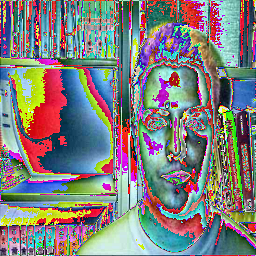

In [ ]:
img, label = image_dataset[50]
print(f'{label=}')
transforms.functional.to_pil_image(img)

# Tasks:

1. Download pretrained Resnet18 model from torchhub
2. Modify the model for object 101 dataset subset (The dataset has 101 distinct classes).
3. Split the dataset between training and validation set (80% / 20%).
4. Fine tune the model for classification on the dataset.
5. Output the fine tuned model's overall accuracy on the validation set.
6. Find a way to show label wise performance/accuracy of the finetuned model.

# Creating the Model

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mean, std, root='.', train=True):
        if train:
            self.transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
            self.dataset = torchvision.datasets.ImageFolder(root=root, transforms=transforms)
            self.dataset = torch.utils.data.random_split(self.dataset, 0.8)

        else:
            self.transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
            self.dataset = torchvision.datasets.ImageFolder(root=root, transforms=transforms)
            self.dataset = torch.utils.data.random_split(self.dataset, 0.2)

        self.train = train

    def __get_item__(self, idx):
        return dataset[idx]

    def __len__(self):
        return len(dataset)

In [ ]:
train_set = MyDataset(root='101_ObjectCategories', mean, std, train=True)
val_set = MyDataset(root='101_ObjectCategories', mean, std, train=False)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # Loading a pretrained ResNet18 model using provided weights in pytorch's documentation

In [ ]:
# Printing the model architecture to get a better understanding
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freezing all parameters in order to stop the training from affecting previously trained parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# We will only adjust the final field classifier layer (fc) which is a Linear layer
# By adjusting it, the parameters will have requires_grad = True allowing for learning
# to only occur on the final layer.
# According to the model architecture, there are 512 input featurs. We chose 101 output features as there are 101 classes to choose from
model.fc = nn.Linear(in_features=512, out_features=101)

# Training the Model

In [ ]:
# Defining the training function
def train(model, epochs, optimizer, criterion, device, scheduler=None):
    # Lists to keep track of the losses for plotting later
    val_losses = []
    train_losses = []

    # Iterating over epochs
    for epoch_num in range(epochs):
        model.train() # Sets the model in training mode

        epoch_losses = 0

        # Looping over batches for each epoch
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x) # Forward pass

            loss = criterion(batch_y_preds, batch_y) # Calculating the loss per batch

            optimizer.zero_grad()
            loss.backward() # Backwards pass
            optimizer.step() # Updating parameters

            epoch_losses += (len(batch_y)*loss.item()) # Keeping track of the losses per batch

        epoch_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss) # Keeping training track of the loss per epoch

        model.eval() # Sets the model in evaluation mode for validation
        correctly_labelled = 0
        with torch.no_grad(): # Disables gradient calculation
            val_epoch_losses = 0
            for val_batch_x, val_batch_y in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x) # Predictions
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

                correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item() # Tracking total correct predictions

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss) # Tracking epoch validation loss

        if scheduler:
            scheduler.step() # Updating the learning rate scheduler if one was provided
            print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={scheduler.get_last_lr()[0]:.4f} train_loss={epoch_loss:.2f}, val_loss={val_epoch_loss:.2f}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100:.2f}% accuracy)')
        else:
            print(f'Epoch: {epoch_num+1}/{epochs}, train_loss={epoch_loss:.2f}, val_loss={val_epoch_loss:.2f}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100:.2f}% accuracy)')
    print('Training Done')
    return train_losses, val_losses # Returns the losses in order to keep track of them

In [ ]:
lr = 5e-4 # Learning rate, it is initially bigger for faster learning but will be changed to smaller value (1e-4) for fine tuning using a scheduler

num_epochs=10 # Number of epochs, it is low to avoid overfitting
weight_decay = 1e-2 # L2 Regularization used to reduce overfitting, it works according to w[t+1] = w[t] - learning_rate * dw - weight_decay * w where w is the weight

criterion = nn.CrossEntropyLoss() # Cross Entropy Loss is used as this is a classifier
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam's optimizer is used

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7) # A scheduler that will multiply the lr by gamma after step_size epochs

model = model.to(device)

## First training with frozen layers

In [ ]:
# Training the model
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/10, learning_rate=0.0005 train_loss=3.03, val_loss=1.89. labelled 1122/1735 correctly (64.67% accuracy)
Epoch: 2/10, learning_rate=0.0005 train_loss=1.46, val_loss=1.14. labelled 1416/1735 correctly (81.61% accuracy)
Epoch: 3/10, learning_rate=0.0005 train_loss=0.93, val_loss=0.82. labelled 1518/1735 correctly (87.49% accuracy)
Epoch: 4/10, learning_rate=0.0005 train_loss=0.69, val_loss=0.66. labelled 1564/1735 correctly (90.14% accuracy)
Epoch: 5/10, learning_rate=0.0003 train_loss=0.57, val_loss=0.60. labelled 1582/1735 correctly (91.18% accuracy)
Epoch: 6/10, learning_rate=0.0003 train_loss=0.49, val_loss=0.55. labelled 1580/1735 correctly (91.07% accuracy)
Epoch: 7/10, learning_rate=0.0003 train_loss=0.46, val_loss=0.53. labelled 1590/1735 correctly (91.64% accuracy)
Epoch: 8/10, learning_rate=0.0003 train_loss=0.43, val_loss=0.51. labelled 1593/1735 correctly (91.82% accuracy)


In [ ]:
# Function to plot the training losses and validation losses vs epochs. This will help identify overfitting and model performance
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend()
    plt.show()

In [ ]:
plot_losses(train_losses, val_losses)

## Second training with unfrozen layers

In [ ]:
# Unfreezing the rest of the layers to allow for fine tuning the pretrained layers
for param in model.parameters():
    param.require_grad = True

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

In [ ]:
plot_losses(train_losses, val_losses)

# Final Results

In [ ]:
model.eval() # Sets the model in evaluation mode for validation
correctly_labelled = 0
with torch.no_grad(): # Disables gradient calculation
    val_epoch_losses = 0
    for val_batch_x, val_batch_y in val_loader:
        val_batch_x = val_batch_x.to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_preds = model(val_batch_x) # Predictions
        correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item() # Tracking total correct predictions
print(f'Labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100:.2f}% accuracy)')